# Forecasting Use of a City Bikeshare System

We chose the Kaggle Bike Sharing Demand competition since it seemed like a practical reasonable question that we might be faced with in our careers as Data Scientists. You can find the problem statement here: https://www.kaggle.com/c/bike-sharing-demand

In [25]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cross_validation import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error 
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor,BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder,Binarizer
import time
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

Feature engineering: There are a couple of changes we made to our data set to get a better feature set:

1. Extract hour, day of the week, month and year information from the "datetime" column in the data.
2. Since the "temp" and "atemp" values are highly correlated, we removed the "atemp" column from our final training data.
3. We converted weather, season, day of the week, month and year columns to factors using one-hot encoding.

In [26]:
#Read the data from the file
data = pd.read_csv('train_interim.csv',sep = ',',header = 0)

#Extract hour,month,day, and year information from the date time values
datetime_data = data[["datetime"]].values
hour_data = []
weekday_data = []
month_data = []
year_data = []
for dates in datetime_data:
    work = time.strptime(dates[0], "%Y-%m-%d %H:%M:%S")
    hour_data.append(work.tm_hour)
    weekday_data.append(work.tm_wday)
    month_data.append(work.tm_mon)
    year_data.append(work.tm_year)
    

data[["datetime"]] = hour_data
data["month"]= month_data
data["weekday"] = weekday_data
data["year"] = year_data

#Add the hour,day,month and year values as new features to the data set
X_data = data[["datetime","season","holiday","workingday","weather","temp","humidity","windspeed","month","weekday","year"]]
X_labels = data[["count"]]
X_labels = np.ravel(X_labels)

#Separate date into training and test
train_data,test_data,train_labels,test_labels = train_test_split(X_data,X_labels,test_size = 0.2)


#-------------------------Data Preprocessing-------------------------------------------------------

#Encode categorical features - for this data set, they are season, workingday, holiday, weather, day of the week, month and year
one_hot_encoder = OneHotEncoder(categorical_features=[1,2,3,4,8,9,10])
train_data_preprocessed = one_hot_encoder.fit_transform(train_data).toarray()
test_data_preprocessed = one_hot_encoder.transform(test_data).toarray()
X_train = one_hot_encoder.fit_transform(X_data).toarray()

Next, we made some plots to explore the features and their relationships to determine which features will inform our models the most. The first plot was a correlation heat map (where red is a strong positive correlation and blue is a strong negative correlation; grey values are not well correlated).

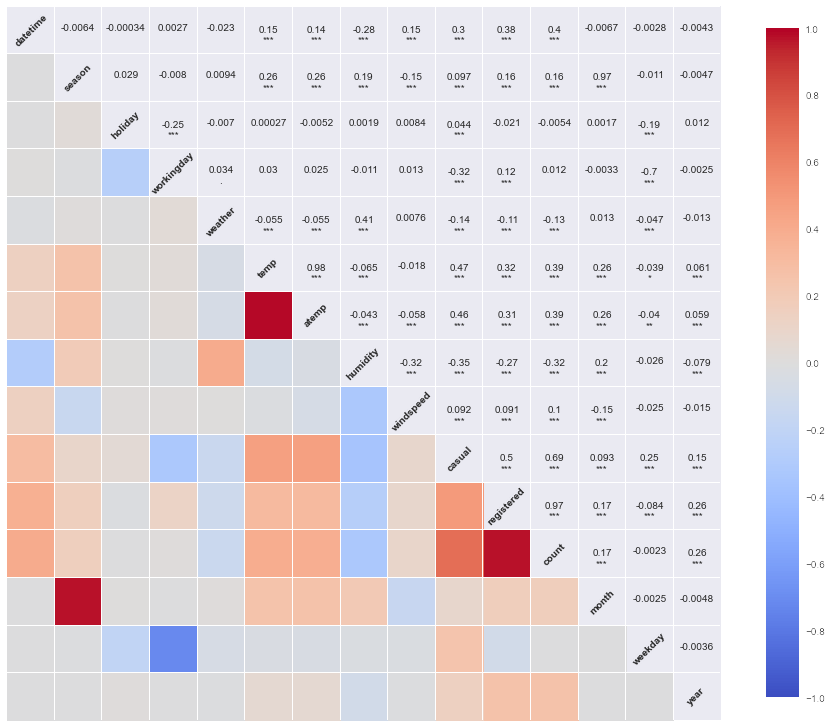

In [27]:
# Use seaborn to create a correlation heat map (red is strong positive correlation; blue is strong negative correlation)
f, ax = plt.subplots(figsize=(16, 16))
sns.corrplot(data, ax=ax);

The two strongest correlations are (1) temp and atemp and (2) registered users and count. Because of this, we decided not to include atemp in our models as it wouldn't give us much additional information than the temp feature. We also directly visualized some of these relationships.

Temperature is positively correlated with the total count of riders:

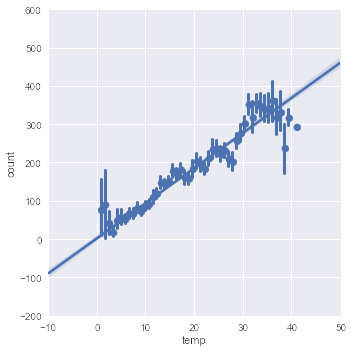

In [28]:
sns.lmplot("temp", "count", data, x_estimator=np.mean);

Humidity is negatively correlated with the total count of riders:

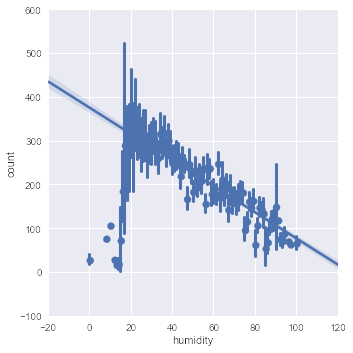

In [29]:
sns.lmplot("humidity", "count", data, x_estimator=np.mean);

Clearly the hour of the day has some predictive power over the total count of riders:

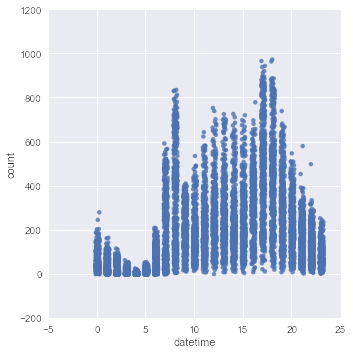

In [20]:
# datetime has been converted to hour
sns.lmplot("datetime", "count", data, x_jitter=.2, fit_reg=False);

Looking at count vs. weekday, the numbers seem steady no matter what day of the week it is:

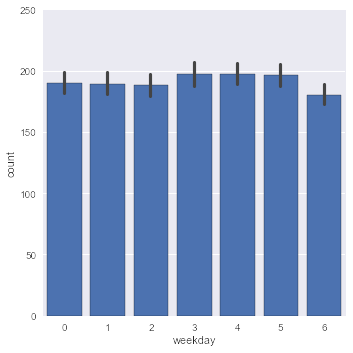

In [31]:
sns.factorplot("weekday","count",data=data);

But what if we look at registered riders only?:

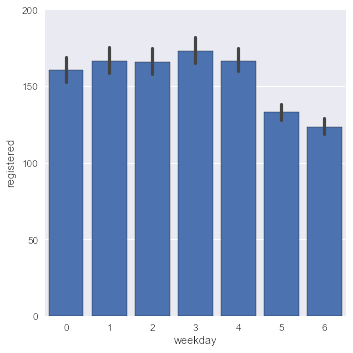

In [34]:
sns.factorplot("weekday","registered",data=data);

Columns 5 and 6 are Saturday and Sunday; it looks like registered riders ride more often during the weekdays. How about the casual riders?:

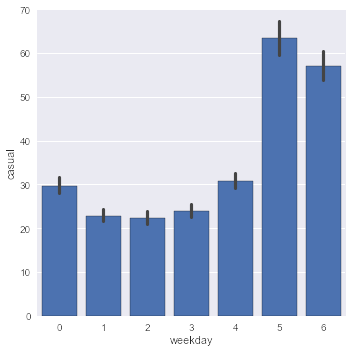

In [33]:
sns.factorplot("weekday","casual",data=data);

Casual riders are definitely more likely on the weekends. We can use this information later on by creating two separate models: one to predice casual riders and another to predict registered riders (and then sum the two values to predict a total count).

### Model Exploration

We started our model exploration by using a K nearest neighbors model with 30 neighbors. The intuition here was that "count" would be predicted based on the values of "count" for its nearest neighbors, and since the counts in one particular month will generally be quite similar to each other (due to seasonal factors), we'll get a better estimate of the count. The root log mean squared error we got was 1.02, which was only slightly better than our baseline submission, that consisted of a simple linear regression model. One possible reason for the bad performance could be that we're considering all the training data, and not just data dating back to just 1 or 2 months (especially for the year 2012), which could mean that the values are all over the place.

In [4]:
#Use a KNeighboursRegressor with 30 neighbours

clf = KNeighborsRegressor(n_neighbors = 30)
clf.fit(train_data_preprocessed,train_labels)
predictions = clf.predict(test_data_preprocessed)
#Convert the predictions to the integer datatype
predictions_int = predictions.astype(int)

#Calculate the root log mean squared error - this is the metric used on the Kaggle leaderboard to rank results
rlmse = 0
for i in range(len(test_labels)):
    rlmse += (np.log(test_labels[i]+1) - np.log(max(0,predictions_int[i]) + 1))**2

print "%.2f" %np.sqrt(rlmse/len(predictions_int))

1.02


Next, we considered a gradient boosting regressor. The idea here was to improve on our baseline linear regression model, by iteratively improving the quality of prediction by optimizing on the loss function. We tried a few loss functions, and found 'lad' i.e. least absolute deviation, along with a learning rate of 0.01, was the one that gave the best results. However, this model takes much longer to train, compared to most of the other models that we worked with.

In [5]:
#Use a Gradient Boosting Regressor as a prediction model. 
clf = GradientBoostingRegressor(n_estimators = 2500, max_depth = 4, learning_rate = 0.01, random_state = 0, loss = 'lad')
clf.fit(train_data_preprocessed,train_labels)
predictions = clf.predict(test_data_preprocessed)
predictions_int = predictions.astype(int)

#Calculate the root log mean squared error.
rlmse = 0
for i in range(len(test_labels)):
    rlmse += (np.log(test_labels[i]+1) - np.log(max(0,predictions_int[i]) + 1))**2
print np.sqrt(rlmse/len(predictions_int))


0.481257724986


We also used the RandomForestRegressor to evaluate its performance on the data. Tree-based models work best on non-sparse data,
so our dataset was perfect for using this prediction model. After performing hyperparametric optimization, a RandomForestRegressor with 50 estimators produced the least error on the dev data.

In [6]:
#Use the RandomForestRegressor as a prediction model. 

clf = RandomForestRegressor(n_estimators = 50)
clf.fit(train_data_preprocessed,train_labels)
predictions = clf.predict(test_data_preprocessed)
predictions_int = predictions.astype(int)
rlmse = 0
#Calculate the root log mean squared error.

for i in range(len(test_labels)):
    rlmse += (np.log(test_labels[i]+1) - np.log(max(0,predictions_int[i]) + 1))**2

print "%.2f" %np.sqrt(rlmse/len(predictions_int))




0.36


The dataset contains 2 variables "casual" and "registered" that add up to the "count" variable. We thought that creating two models, one to predict the "casual" variable, and the other to predict the "registered" variable, and then summing up the predictions to product the final "count" variable, would produce a better fit for the data, with lesser error. The final model that we used (and this was also the one that was our final submission on Kaggle), consisted of a decision tree that we trained on the data, and then performed bagging to iteratively improve the quality of prediction. Although we got pretty good results using the random forest, it's something that's hard to visualize intuitively, and the bagging model gave us slightly better results as well.

In [7]:

#Run 2 models - one for predicting casual cyclists, and the other for predicting registered cyclists, then add the two
#predictions to get the final value of bike demand.

#Separate date into training and test
train_data_all,test_data_all = train_test_split(data,test_size = 0.2)

#Select desired columns
train_data = train_data_all[:,(0,1,2,3,4,5,6,7,8,12,13,14)]
test_data = test_data_all[:,(0,1,2,3,4,5,6,7,8,12,13,14)]
train_labels_casual = np.ravel(train_data_all[:,9])
train_labels_registered = np.ravel(train_data_all[:,10])
test_labels_casual = np.ravel(test_data_all[:,9])
test_labels_registered = np.ravel(test_data_all[:,10])


#-------------------------Data Preprocessing-------------------------------------------------------

#Encode categorical features.
one_hot_encoder = OneHotEncoder(categorical_features=[1,2,3,4,9,10,11])
train_data_preprocessed = one_hot_encoder.fit_transform(train_data).toarray()
test_data_preprocessed = one_hot_encoder.fit_transform(test_data).toarray()


#-----------------------Run the model---------------------------------------------------------------

#Model 1 - predict casual users

#Train the decision tree on the training data.
clf_casual = DecisionTreeRegressor(min_samples_split = 4,min_samples_leaf = 2,max_depth = 150)
clf_casual.fit(train_data_preprocessed,train_labels_casual)

#Use bagging to improve the quality of predictions.
bagging_casual = BaggingRegressor(base_estimator = clf_casual,n_estimators = 150,oob_score=True)
bagging_casual.fit(train_data_preprocessed,train_labels_casual)
predictions = bagging_casual.predict(test_data_preprocessed)
predictions_int_casual = predictions.astype(int)

#Model 2 - predict registered users

#Train the decision tree on the training data.
clf_registered = DecisionTreeRegressor(min_samples_split = 4,min_samples_leaf = 2,max_depth=150)
clf_registered.fit(train_data_preprocessed,train_labels_registered)

#Use bagging to improve the quality of predictions.
bagging_registered = BaggingRegressor(base_estimator = clf_registered,n_estimators = 150,oob_score=True)
bagging_registered.fit(train_data_preprocessed,train_labels_registered)
predictions = bagging_registered.predict(test_data_preprocessed)
predictions_int_registered = predictions.astype(int)

#Add the predictions from the 2 models to arrive at the final value of the "count" variable
predictions_int = predictions_int_casual + predictions_int_registered
test_labels = test_labels_casual.astype(int) + test_labels_registered.astype(int)


#Calculate the root log mean squared error.
rlmse = 0
for i in range(len(test_labels)):
    rlmse += (np.log(test_labels[i]+1) - np.log(max(0,predictions_int[i]) + 1))**2

print "%.2f" %np.sqrt(rlmse/len(predictions_int))

#Perform 10-fold cross validation using the mean squared error as a metric.
cross_val_scores_casual = cross_val_score(bagging_casual,train_data_preprocessed,train_labels_casual,cv=10,scoring='mean_squared_error')
print cross_val_scores_casual

cross_val_scores_reg = cross_val_score(bagging_registered,train_data_preprocessed,train_labels_registered,cv=10,scoring='mean_squared_error')
print cross_val_scores_reg



0.31
[-214.15844849 -218.16672347 -261.62979397 -219.06647916 -237.57394406
 -195.10267953 -235.24290655 -186.93625249 -204.83814022 -218.46495345]
[ -909.77554742 -1447.96956178 -1193.00845711 -1185.79901824  -996.23421277
 -1152.0895662  -1103.17165148 -1028.35662065 -1609.67881333 -1074.71188498]


In [8]:
"""
Created a pipeline to search for optimal parameters for the decision tree and the bagging Model
Best parameters: 
1. Decision tree: min_samples_split = 4,min_samples_leaf = 2,max_depth = 150
2. BaggingRegressor: n_estimators = 150,oob_score=True
"""


#Perform hyperparametric optimization for the decision tree.
pipeline = Pipeline([('clf_tree',DecisionTreeRegressor())])

parameters = {'clf_tree__splitter':('best','random'),'clf_tree__max_depth' : (50,150,250), 'clf_tree__min_samples_split' : (1,2,3),'clf_tree__min_samples_leaf' : (1,2,3)}

grid_search = GridSearchCV(pipeline,parameters,n_jobs = -1,verbose = 1,scoring = 'mean_squared_error')
grid_search.fit(train_data_preprocessed,train_labels)
print "Best score %.3f" %grid_search.best_score_
print "Best parameters set: "
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(best_parameters.keys()):
    print "%s : %r" %(param_name,best_parameters[param_name])


#Train the decision tree with the optimal parameters, and use it as a base estimator for the bagging model.
clf = DecisionTreeRegressor(min_samples_split = 4,min_samples_leaf = 2,max_depth = 150)
clf.fit(train_data_preprocessed,train_labels)    

#Perform hyperparametric optimization for the bagging regressor.
pipeline = Pipeline([('clf_bagging',BaggingRegressor(base_estimator = clf))])

parameters = {'clf_bagging__n_estimators':(50,70,100,120,150),'clf_bagging__oob_score' : (True,False)}

grid_search = GridSearchCV(pipeline,parameters,n_jobs = -1,verbose = 1,scoring = 'mean_squared_error')
grid_search.fit(train_data_preprocessed,train_labels)
print "Best score %.3f" %grid_search.best_score_
print "Best parameters set: "
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(best_parameters.keys()):
    print "%s : %r" %(param_name,best_parameters[param_name])
        


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    1.7s finished


Best score -46988.595
Best parameters set: 
clf_tree : DecisionTreeRegressor(compute_importances=None, criterion='mse',
           max_depth=150, max_features=None, max_leaf_nodes=None,
           min_density=None, min_samples_leaf=3, min_samples_split=1,
           random_state=None, splitter='random')
clf_tree__compute_importances : None
clf_tree__criterion : 'mse'
clf_tree__max_depth : 150
clf_tree__max_features : None
clf_tree__max_leaf_nodes : None
clf_tree__min_density : None
clf_tree__min_samples_leaf : 3
clf_tree__min_samples_split : 1
clf_tree__random_state : None
clf_tree__splitter : 'random'
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   25.9s finished


Best score -36076.279
Best parameters set: 
clf_bagging : BaggingRegressor(base_estimator=DecisionTreeRegressor(compute_importances=None, criterion='mse',
           max_depth=150, max_features=None, max_leaf_nodes=None,
           min_density=None, min_samples_leaf=2, min_samples_split=4,
           random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=150, n_jobs=1, oob_score=True,
         random_state=None, verbose=0)
clf_bagging__base_estimator : DecisionTreeRegressor(compute_importances=None, criterion='mse',
           max_depth=150, max_features=None, max_leaf_nodes=None,
           min_density=None, min_samples_leaf=2, min_samples_split=4,
           random_state=None, splitter='best')
clf_bagging__base_estimator__compute_importances : None
clf_bagging__base_estimator__criterion : 'mse'
clf_bagging__base_estimator__max_depth : 150
clf_bagging__base_estimator__max_features : None
clf_bagg

During training, we trained all our models on the entire training data (and not only on data occurring prior to the date in the test data). While making the final submission, we added extra code to train models only on data occurring prior to the date in the test data.

In [10]:
#Make submission using the Decision Tree + Bagging model.
#Read the data from the file

data = pd.read_csv('train.csv',sep = ',',header = 0)

#Extract hour from the date time values
datetime_data = data[["datetime"]].values
hour_data = []
weekday_data = []
month_data = []
year_data = []

for dates in datetime_data:
    work = time.strptime(dates[0], "%Y-%m-%d %H:%M:%S")
    hour_data.append(work.tm_hour)
    weekday_data.append(work.tm_wday)
    month_data.append(work.tm_mon)
    year_data.append(work.tm_year)

data[["datetime"]] = hour_data
data["month"]= month_data
data["weekday"] = weekday_data
data["year"] = year_data

train_data = data[["datetime","season","holiday","workingday","weather","temp","humidity","windspeed","month","weekday","year"]]
train_labels_casual = np.ravel(data[["casual"]])
train_labels_registered = np.ravel(data[["registered"]])

test_data = pd.read_csv('test.csv',sep = ',',header = 0)

hour_data = []
weekday_data = []
month_data = []
year_data = []

sample_data = test_data["datetime"]
datetime_data = test_data[["datetime"]].values

for dates in datetime_data:
    work = time.strptime(dates[0], "%Y-%m-%d %H:%M:%S")
    hour_data.append(work.tm_hour)
    weekday_data.append(work.tm_wday)
    month_data.append(work.tm_mon)
    year_data.append(work.tm_year)

test_data[["datetime"]] = hour_data
test_data["month"]= month_data
test_data["weekday"] = weekday_data
test_data["year"] = year_data

test_data = test_data[["datetime","season","holiday","workingday","weather","temp","humidity","windspeed","month","weekday","year"]]

#-------------------------Data Preprocessing-------------------------------------------------------

#Encode categorical features.
one_hot_encoder = OneHotEncoder(categorical_features=[1,2,3,4,8,9,10])
train_data_preprocessed = one_hot_encoder.fit_transform(train_data).toarray()
test_data_preprocessed = one_hot_encoder.fit_transform(test_data).toarray()


#---------------------Run the model---------------------------------------------------------------------------
#Run this loop 24 times, to account for the 24 months in the test data
past = 0
all_predictions = []
for i in range(1,25):
    #each model should contain the training data for the first 19 days of that month + the training data from previous months
    n_train = 19*24*i 
    training_data = train_data_preprocessed[:n_train]
    training_labels_casual = train_labels_casual[:n_train]
    training_labels_reg = train_labels_registered[:n_train]
    #check to see if month has 31 days, 30 days or 28, and based on this choose testing data
    if i in [4,6,9,11,16,18,21,23]:
       n_test = 11*24
    elif i in [2,14]:
        n_test = 9*24
    else:
        n_test = 12*24
    n_test += past
    #testing data should only contain the last 9,11,or 12 days of the month, depending on the type of month
    testing_data = test_data_preprocessed[past:n_test]
    past = n_test
    
    clf_casual = DecisionTreeRegressor(min_samples_split = 4,min_samples_leaf = 2,max_depth = 150)
    clf_casual.fit(training_data,training_labels_casual)
   
    bagging_casual = BaggingRegressor(base_estimator = clf_casual,n_estimators = 150)
    bagging_casual.fit(training_data,training_labels_casual)
    predictions_casual = bagging_casual.predict(testing_data)

    clf_registered = DecisionTreeRegressor(min_samples_split = 4,min_samples_leaf = 2,max_depth = 150)
    clf_registered.fit(training_data,training_labels_reg)

    bagging_registered = BaggingRegressor(base_estimator = clf_registered,n_estimators = 150)
    bagging_registered.fit(training_data,training_labels_reg)
    predictions_reg = bagging_registered.predict(testing_data)
    
    for i in range(len(predictions_casual)):
        all_predictions.append(int(predictions_casual[i]) + int(predictions_reg[i]))

df_sub = pd.DataFrame({ 'datetime' : sample_data,'count' : all_predictions})
df_sub.head()
df_sub.to_csv('submission_2models_reduced.csv',index=False,cols=["datetime","count"])



We also submitted results from our random forest model to Kaggle. This was prior to making our final submission, just to evaluate its performance on the actual test data.

In [11]:
#Let's take into account dates only before the test input date

data = pd.read_csv('train.csv',sep = ',',header = 0)
datetime_data = data[["datetime"]].values
hour_data = []
for dates in datetime_data:
    work = time.strptime(dates[0], "%Y-%m-%d %H:%M:%S")
    hour_data.append(work.tm_hour)

data[["datetime"]] = hour_data

train_data = data[["datetime","season","holiday","workingday","weather","temp","atemp","humidity","windspeed"]]
train_labels = data[["count"]]

train_labels = np.ravel(train_labels)

test_data = pd.read_csv('test.csv',sep = ',',header = 0)

hour_data = []
sample_data = test_data["datetime"]
datetime_data = test_data[["datetime"]].values

for dates in datetime_data:
    work = time.strptime(dates[0], "%Y-%m-%d %H:%M:%S")
    hour_data.append(work.tm_hour)

test_data[["datetime"]] = hour_data

#-------------------------Data Preprocessing-------------------------------------------------------
one_hot_encoder = OneHotEncoder(categorical_features=[1,2,3,4])
train_data_preprocessed = one_hot_encoder.fit_transform(train_data).toarray()
test_data_preprocessed = one_hot_encoder.fit_transform(test_data).toarray()


#---------------------Run the model---------------------------------------------------------------------------
#Run this loop 24 times, to account for the 24 months in the test data
past = 0
predictions = []
all_predictions = []
for i in range(1,25):
    #each model should contain the training data for the first 19 days of that month + the training data from previous months
    n_train = 19*24*i 
    training_data = train_data_preprocessed[:n_train]
    training_labels = train_labels[:n_train]
    #check to see if month has 31 days, 30 days or 28, and based on this choose testing data
    if i in [4,6,9,11,16,18,21,23]:
       n_test = 11*24
    elif i in [2,14]:
        n_test = 9*24
    else:
        n_test = 12*24
    n_test += past
    #testing data should only contain the last 9,11,or 12 days of the month, depending on the type of month
    testing_data = test_data_preprocessed[past:n_test]
    past = n_test
    
    clf = RandomForestRegressor(n_estimators = 50,max_depth = 150,min_samples_split = 3,min_samples_leaf = 1)
    clf.fit(training_data,training_labels)
    
    predictions = clf.predict(testing_data)
    for item in predictions:
        all_predictions.append(int(item))

df_sub = pd.DataFrame({ 'datetime' : sample_data,'count' : all_predictions})
df_sub.head()
df_sub.to_csv('submission_new.csv',index=False,cols=["datetime","count"])


Error Analysis

Some examples of misclassfication using various models

In [5]:
from IPython.display import HTML
s = """<table>
<tr>
<th>Model</th>
<th>RLMSE</th>
<th># exact predictions</th>
<th>most extreme difference</th>
</tr>
<tr>
<td>GradientBoostingRegressor</td>
<td>0.705</td>
<td>31</td>
<td>440</td>
</tr>
<tr>
<td>KNeighboursRegressor</td>
<td>1.027</td>
<td>13</td>
<td>598</td>
</tr>
<tr>
<td>RandomForestRegressor</td>
<td>0.319</td>
<td>67</td>
<td>456</td>
</tr>
<tr>
<td>AdaBoostRegressor</td>
<td>0.799</td>
<td>11</td>
<td>589</td>
</tr>
<tr>
<td>DecisionTreeRegressor</td>
<td>0.394</td>
<td>57</td>
<td>603</td>
</tr>
<tr>
<td>BaggingRegressor</td>
<td>0.315</td>
<td>77</td>
<td>442</td>
</tr>
</table>"""
h = HTML(s); h

Model,RLMSE,# exact predictions,most extreme difference
GradientBoostingRegressor,0.705,31,440
KNeighboursRegressor,1.027,13,598
RandomForestRegressor,0.319,67,456
AdaBoostRegressor,0.799,11,589
DecisionTreeRegressor,0.394,57,603
BaggingRegressor,0.315,77,442
